In [8]:
import pandas as pd
import glob
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Spectral Preprocessing

In [9]:
input_dir = "raw_spectral_groups"
output_dir = "compiled_spectral_groups"
os.makedirs(output_dir, exist_ok=True)

group_dirs = glob.glob(f"{input_dir}/*")
group_names = ["bud_inflorescence", "flower_inflorescence", "fresh_flowers"]

for i, (group, name) in enumerate(zip(group_dirs, group_names)):
    csv_dirs = glob.glob(f"{group}/*.csv")
    csv_raw = [pd.read_csv(file, skiprows=2, names=['wavenumber', 'absorbance']) for file in csv_dirs]
    csv_trans = [file['absorbance'] for file in csv_raw]
    group_df = pd.concat(csv_trans, axis=1)
    group_df.columns=[f"{name}_{i}" for i in range(1,len(csv_trans)+1)]

    group_df.to_csv(f"{output_dir}/{name}.csv", index=False)

    if i == 0:
        wavenumber = csv_raw[0]['wavenumber']
        wavenumber.to_csv("wavenumber.csv", index=False)

Spectral Visualization

In [10]:
compiled_csv_dirs = glob.glob(f"{output_dir}/*")
bud_inflorescence, flower_infloresence, fresh_flowers = [pd.read_csv(group) for group in compiled_csv_dirs]
compiled_groups = [bud_inflorescence, flower_infloresence, fresh_flowers]
formal_group_names = ["Bud Inflorescence", "Flower Inflorescence", "Fresh Flowers"]

wavenumber = pd.read_csv("wavenumber.csv")

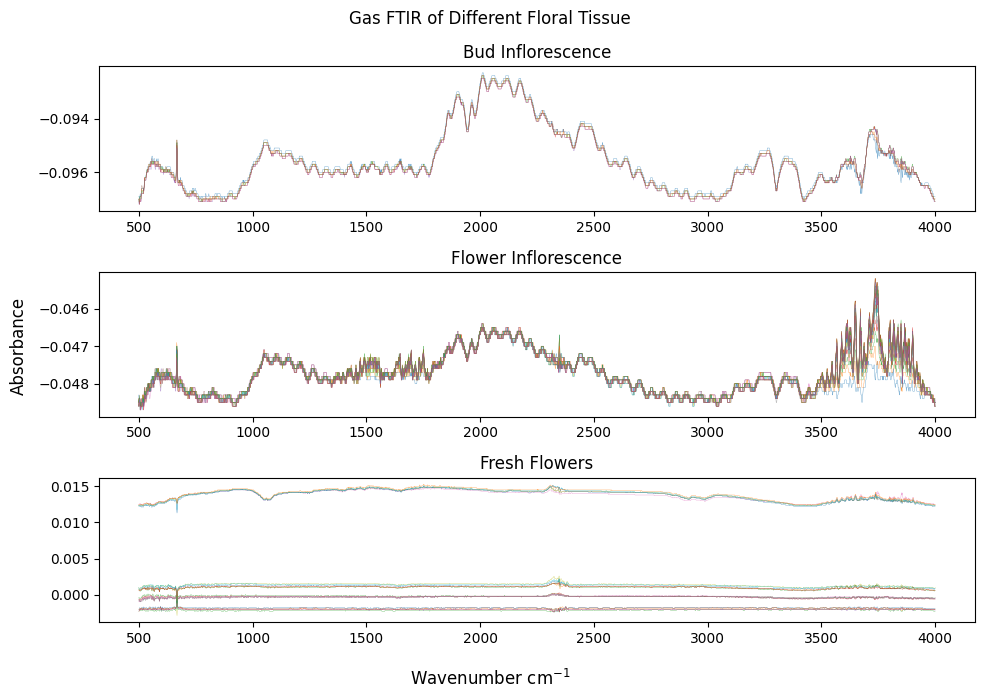

In [11]:
sep_fig, sep_axes = plt.subplots(3,1, figsize=(10,7))

sep_fig.suptitle("Gas FTIR of Different Floral Tissue")
sep_fig.supxlabel("Wavenumber cm$^{-1}$")
sep_fig.supylabel("Absorbance")

for axis, group, name in zip(sep_axes, compiled_groups, formal_group_names):
    axis.plot(wavenumber, group, linewidth=0.2)
    axis.set(title=name)

sep_fig.tight_layout()


Principal Component Analysis (Whole Spectra)

In [20]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [21]:
def pca_compile(df_list, class_list):
    wavenumber = pd.read_csv("wavenumber.csv", header=0)
    transformed_df = [df.T.reset_index(drop=True) for df in df_list]

    for df, class_name in zip(transformed_df, class_list):
        df.columns = wavenumber['wavenumber']
        df['class'] = class_name

    main_df = pd.concat(transformed_df, axis=0, ignore_index=True)
    main_df.columns.name = None

    return main_df

In [24]:
def run_pca(main_df):
    pca = PCA(n_components=2)
    scaler = StandardScaler()
    y = main_df.pop('class')
    X = main_df
    X = scaler.fit_transform(X)

    pca_result = pca.fit_transform(X)
    pca_df = pd.DataFrame(pca_result, columns=['PC 1', 'PC 2'])

    fig, ax = plt.subplots()

    # sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=y)
    # sns.kdeplot(data=pca_df, x='PC1', y='PC2', levels=4)

    unique_classes = y.unique()
    colors = plt.get_cmap('viridis', len(unique_classes))

    for i, class_name in enumerate(unique_classes):
        # Mask the data to select only points of the current class
        mask = (y == class_name)
        ax.scatter(pca_df[mask]['PC 1'], pca_df[mask]['PC 2'], label=str(class_name),
                   color=colors(i), marker='o')

    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.legend(title="Class", fontsize=7)

    plt.show()

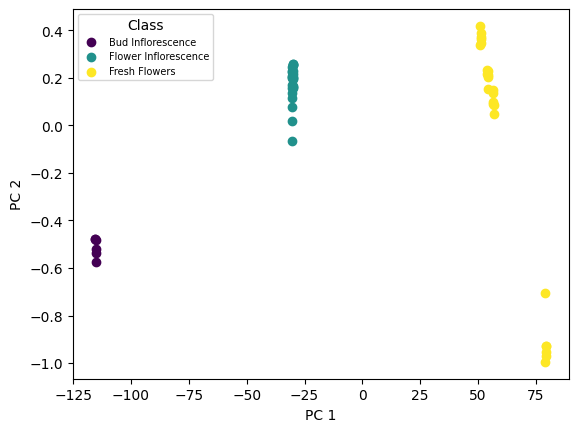

In [25]:
compiled_csv_dirs = glob.glob(f"{output_dir}/*")
bud_inflorescence, flower_infloresence, fresh_flowers = [pd.read_csv(group) for group in compiled_csv_dirs]
compiled_groups = [bud_inflorescence, flower_infloresence, fresh_flowers]
formal_group_names = ["Bud Inflorescence", "Flower Inflorescence", "Fresh Flowers"]

wavenumber = pd.read_csv("wavenumber.csv")

main_df = pca_compile(compiled_groups, formal_group_names)
run_pca(main_df)